In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

import gc

#### Загрузка всех необходимых таблиц.

In [2]:
names = ['datetime', 'unit_id', 'node_id', 'pdg', 'upper_limit']
df_units = pd.read_csv("units.csv", sep=';', names=names)

* unit_id - режимная генерирующая единица
* node_id - узел расчетной модели
* pdg - плановый объем производства
* upper_limit - верхний предел производства

Информация предоставлена за каждый час.

In [3]:
df_units['datetime'] = pd.to_datetime(df_units['datetime'], format='%Y-%m-%d %H:%M')
df_units['date'] = df_units['datetime'].apply(lambda x: str(x.year)+'-'+str(x.month)+'-'+str(x.day))
df_units['date'] = pd.to_datetime(df_units['date'], format='%Y-%m-%d')

df_units['pdg'] = df_units['pdg'].apply(lambda x: x.replace(',', '.'))
df_units['pdg'] = df_units['pdg'].astype(float)

df_units['upper_limit'] = df_units['upper_limit'].apply(lambda x: x.replace(',', '.'))
df_units['upper_limit'] = df_units['upper_limit'].astype(float)

In [4]:
df_units.head()

,datetime,unit_id,node_id,pdg,upper_limit,date
0,2018-10-01,1001,100063,590.0,590.0,2018-10-01
1,2018-10-01,10010,1000805,0.0,0.0,2018-10-01
2,2018-10-01,10011,1000805,0.0,227.0,2018-10-01
3,2018-10-01,10012,1000805,0.0,227.0,2018-10-01
4,2018-10-01,10013,1000805,0.0,242.7,2018-10-01


Преобразую данные из почасовых в дневные. Также удалим информацию о unit_id, т.к. она не требуется для рассмотрения.

In [5]:
df_units.drop(['unit_id'], axis=1, inplace=True)
df_units = pd.DataFrame(df_units.groupby(['date','node_id']
                                        )[['pdg', 'upper_limit']].mean().reset_index())
df_units.head()

,date,node_id,pdg,upper_limit
0,2018-10-01,100004,20.383333,20.383333
1,2018-10-01,100005,12.000000,12.000000
2,2018-10-01,100006,81.468493,100.000000
3,2018-10-01,100008,13.000000,13.000000
4,2018-10-01,100009,6.166667,6.166667


In [6]:
df_indices = pd.read_excel('indices.xlsx')
df_indices['datetime'] = pd.to_datetime(df_indices['datetime'], format='%Y-%m-%d %H:%M')
df_indices['date'] = df_indices['datetime'].apply(lambda x: str(x.year)+'-'+str(x.month)+'-'+str(x.day))
df_indices['date'] = pd.to_datetime(df_indices['date'], format='%Y-%m-%d')

In [7]:
df_indices.head()

,datetime,price_zone,volume_bid,price_bid,date
0,2018-10-01 00:00:00,1 ЦЗ,77106.515625,1204.729980,2018-10-01
1,2018-10-01 00:00:00,2 ЦЗ,19994.501953,543.989990,2018-10-01
2,2018-10-01 01:00:00,1 ЦЗ,75614.718750,987.409973,2018-10-01
3,2018-10-01 01:00:00,2 ЦЗ,20364.927734,580.729980,2018-10-01
4,2018-10-01 02:00:00,1 ЦЗ,74902.093750,982.479980,2018-10-01


Аналогично преобразую данные из почасовых в дневные.

In [8]:
df_indices = pd.DataFrame(df_indices.groupby(['date', 'price_zone']
                                            )[['volume_bid', 'price_bid']].mean().reset_index())
df_indices.head()

,date,price_zone,volume_bid,price_bid
0,2018-10-01,1 ЦЗ,86100.561523,1370.541239
1,2018-10-01,2 ЦЗ,21936.190430,663.804581
2,2018-10-02,1 ЦЗ,86407.180339,1390.640831
3,2018-10-02,2 ЦЗ,21940.536133,678.064163
4,2018-10-03,1 ЦЗ,86431.569010,1415.978747


In [9]:
df_indices['price_zone'].unique()

array(['1 ЦЗ', '2 ЦЗ'], dtype=object)

Всего представлено две ценовых зоны, требуется рассмотреть первую. Данные о второй зоне можно удалить.

In [10]:
condition = df_indices['price_zone'] == '2 ЦЗ'
df_indices.drop(df_indices[condition].index, inplace=True)

In [11]:
df_nodes = pd.read_excel('nodes.xlsx')

In [12]:
df_nodes.head()

,node_id,region
0,1000003,Красноярский край
1,1000003,Красноярский край
2,1000004,Красноярский край
3,1000004,Красноярский край
4,1000005,Красноярский край


In [13]:
df_regions = pd.read_excel('regions.xlsx')

df_regions['name'] = df_regions['region'].apply(lambda x: x.split(' ')[0])
df_regions.iloc[44:61, -1] = df_regions.iloc[44:61, 0].apply(lambda x: x.split(' ')[1])

In [14]:
df_regions.head()

,region,federal_district,price_zone,price_zone_id,name
0,Алтайский край,Сибирский,2 ЦЗ,2,Алтайский
1,Амурская область,Дальневосточный,2 НЦЗ,4,Амурская
2,Архангельская область,Северо-Западный,НЦЗА,3,Архангельская
3,Астраханская область,Южный,1 ЦЗ,1,Астраханская
4,Белгородская область,Центральный,1 ЦЗ,1,Белгородская


In [15]:
df_russia = gpd.read_file('russia/gadm36_RUS_1.shp')

df_russia['name'] = df_russia['NL_NAME_1'].apply(lambda x: str(x).split(' ')[0])
df_russia.iloc[0, -1] = df_russia['NL_NAME_1'].iloc[0].split(' ')[1]
df_russia.iloc[5, -1] = df_russia['NL_NAME_1'].iloc[5].split(' ')[1]
df_russia.iloc[8, -1] = df_russia['NL_NAME_1'].iloc[8].split(' ')[1]
df_russia.iloc[9, -1] = df_russia['NL_NAME_1'].iloc[9].split(' ')[1]
df_russia.iloc[14:17, -1] = df_russia['NL_NAME_1'].iloc[14:17].apply(lambda x: x.split(' ')[1])
df_russia.iloc[21, -1] = df_russia['NL_NAME_1'].iloc[21].split(' ')[1]
df_russia.iloc[28, -1] = df_russia['NL_NAME_1'].iloc[28].split(' ')[1]
df_russia.iloc[31, -1] = df_russia['NL_NAME_1'].iloc[31].split(' ')[1]
df_russia.iloc[40:42, -1] = df_russia['NL_NAME_1'].iloc[40:42].apply(lambda x: x.split(' ')[1])
df_russia.iloc[47, -1] = df_russia['NL_NAME_1'].iloc[47].split(' ')[1]
df_russia.iloc[59, -1] = df_russia['NL_NAME_1'].iloc[59].split(' ')[1]
df_russia.iloc[70, -1] = df_russia['NL_NAME_1'].iloc[70].split(' ')[1]
df_russia.name.iloc[50] = 'Еврейская'

siberia_cond = set(df_regions[df_regions['price_zone'] != '1 ЦЗ']['name'].values)

df_russia.drop(df_russia[df_russia['name'].isin(siberia_cond)].index, inplace=True)
df_russia.index = range(df_russia.shape[0])

/home/ivan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
df_nodes_zone = pd.merge(df_nodes, df_regions, on='region', how='left')
df_nodes_zone['price_zone'].value_counts(dropna=False)

1 ЦЗ    6653
2 ЦЗ    1417
NaN      103
Name: price_zone, dtype: int64

Некоторые регионы не принадлежат ни к одной ценовой зоне (NaN). Псмотрим, какие это регионы.

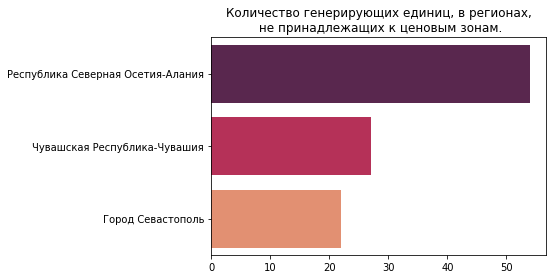

In [17]:
NaN_regions = df_nodes_zone[df_nodes_zone['price_zone'].isna()]['region'].value_counts()
sns.barplot(NaN_regions.values, NaN_regions.index, palette="rocket", orient="h")
plt.title("Количество генерирующих единиц, в регионах,\n не принадлежащих к ценовым зонам.")
plt.show()

Удалим данные из таблиц о всех генерирующих единицах находящихся не в 1ой ценовой зоне.

In [18]:
condition = set(df_nodes_zone[df_nodes_zone['price_zone'] != '1 ЦЗ']['node_id'].values)

df_units.drop(df_units[df_units['node_id'].isin(condition) == True].index, inplace=True)
df_nodes.drop(df_nodes[df_nodes['node_id'].isin(condition) == True].index, inplace=True)

df_regions.drop(df_regions[df_regions['price_zone'] != '1 ЦЗ'].index, inplace=True)

In [19]:
names = ['date', 'node_id', 'price']
df_prices = pd.read_csv('prices_day.csv', sep=';', names=names)
df_prices.head()

,date,node_id,price
0,2018-10-01,100001,1026.8447
1,2018-10-02,100001,1036.8099
2,2018-10-03,100001,1042.5596
3,2018-10-04,100001,919.0223
4,2018-10-05,100001,972.0237


Заметим, что информация о выработке генерирубщими единицами есть не о всех node_id.

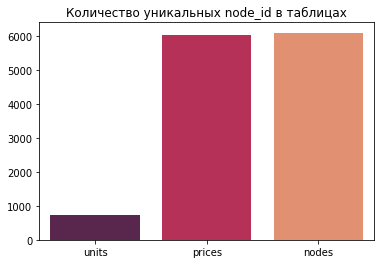

In [20]:
num_units_nodeid = df_units['node_id'].nunique()
num_prices_nodeid = df_prices['node_id'].nunique()
num_nodes_nodeid = df_nodes['node_id'].nunique()
sns.barplot(y=[num_units_nodeid, num_prices_nodeid, num_nodes_nodeid],
            x=['units', 'prices', 'nodes'], palette="rocket")
plt.title('Количество уникальных node_id в таблицах')
plt.show()

Из-за того что данные из таблицы units доступны только для части существующих node_id, предполагается:

* Анализировать только node_id, входящие в units (739 уникальных единиц).
* Анализировать все node_id, без учета данных из таблицы unit.
* Анализировать все node_id, но с заполнением пропусков из таблицы unit.

### Небольшой обзор имеющихся данных.

Рассмотрим распределение по средней выработке генерирующими единицами.

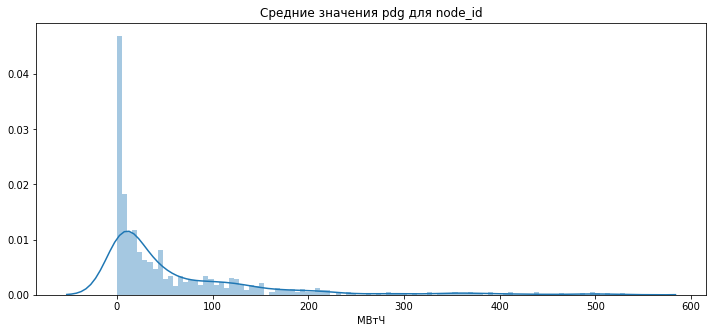

In [21]:
pdg_dist = df_units.groupby('node_id')['pdg'].mean().values

plt.figure(figsize=(12, 5))
sns.distplot(pdg_dist[pdg_dist < 700], bins=100)
plt.title('Средние значения pdg для node_id')
plt.xlabel('МВтЧ')
plt.show()

Рассмотрим, каким регионам принадлежат единицы с наибольшей средней выработкой.

In [293]:
big_nodeid = pd.DataFrame(df_units.groupby('node_id')['pdg'].mean() > 300).reset_index()
big_nodeid = big_nodeid[big_nodeid['pdg'] == True]

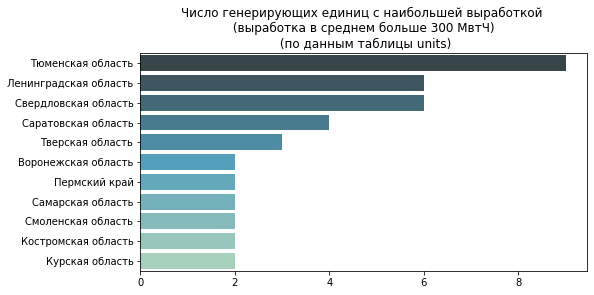

In [323]:
big_regions = pd.merge(big_nodeid, df_nodes, on='node_id', how='left')['region'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(big_regions.values[:11], big_regions.index[:11], palette="GnBu_d")
plt.title('Число генерирующих единиц с наибольшей выработкой \n (выработка в среднем больше 300 МвтЧ) \n (по данным таблицы units)')
plt.show()

Каким регионам принадлежат единицы с наибольшим числом дней простоя (pdg за день равно 0).

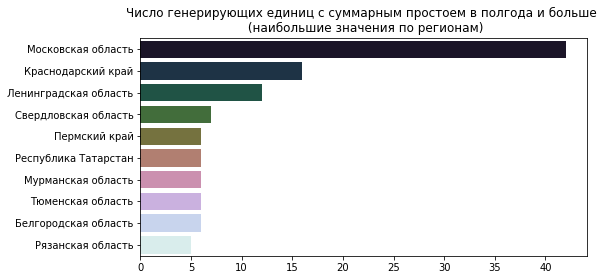

In [63]:
notworking_nodeid = pd.DataFrame(df_units[df_units['pdg'] == 0]['node_id'].value_counts()).reset_index()
notworking_nodeid.columns = ['node_id', 'value']
notworking_regions = pd.merge(notworking_nodeid[notworking_nodeid['value'] > 150], df_nodes, on='node_id', how='left')['region'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(notworking_regions.values[:10], notworking_regions.index[:10], palette='cubehelix')
plt.title("Число генерирующих единиц с суммарным простоем в полгода и больше \n (наибольшие значения по регионам)")
plt.show()

Суммарные мощности генерирующих единиц по каждому региону.

In [24]:
df_units_nodes = pd.merge(df_units, df_nodes, on='node_id', how='left')

sum_pdg_region = pd.DataFrame(df_units_nodes.groupby('region')['pdg'].sum()).reset_index()
sum_pdg_region['name'] = sum_pdg_region['region'].apply(lambda x: x.split(' ')[0])
sum_pdg_region.iloc[27:35, 2] = sum_pdg_region.iloc[27:35, 0].apply(lambda x: x.split(' ')[1])

df_russia_sumpdg = pd.merge(df_russia, sum_pdg_region, left_on='NL_NAME_1', right_on='region')

Суммарные значения средней выработки МВтЧ для генерирующих единиц по регионам.

(некоторыйе регионы на карте отсутсвуют - по техническим причинам)

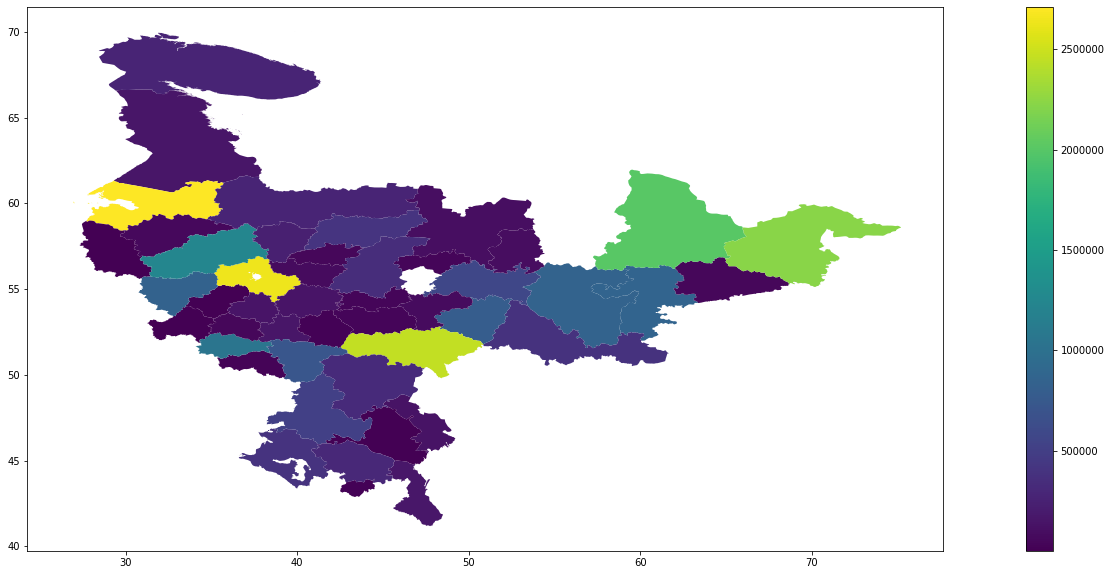

In [25]:
df_russia_sumpdg.plot(column='pdg', figsize=(30, 10), legend=True)

In [26]:
mean_price_region = pd.DataFrame(pd.merge(df_nodes, df_prices, on='node_id').groupby('region')['price'].mean()).reset_index()
mean_price_region['name'] = mean_price_region['region'].apply(lambda x: x.split(' ')[0])
mean_price_region.iloc[27:35, 2] = mean_price_region.iloc[27:35, 0].apply(lambda x: x.split(' ')[1])

df_russia_meanprice = pd.merge(df_russia, mean_price_region, left_on='NL_NAME_1', right_on='region')

Средняя цена в рублях по региону для соответсвующих генерирующих единиц.

(по техническим причинам показаны не все регионы)

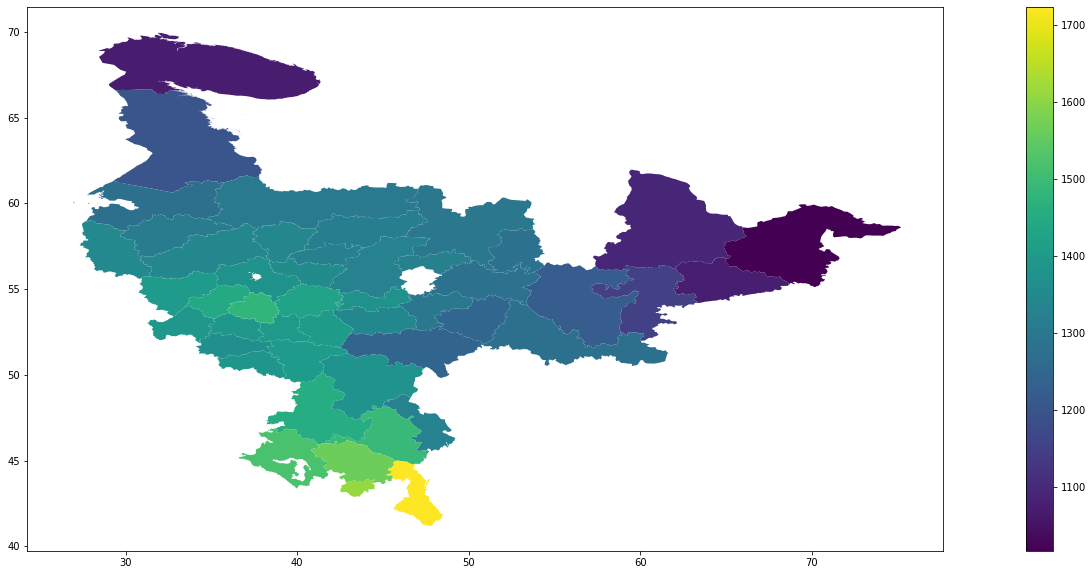

In [27]:
df_russia_meanprice.plot(column='price', figsize=(30, 10), legend=True)

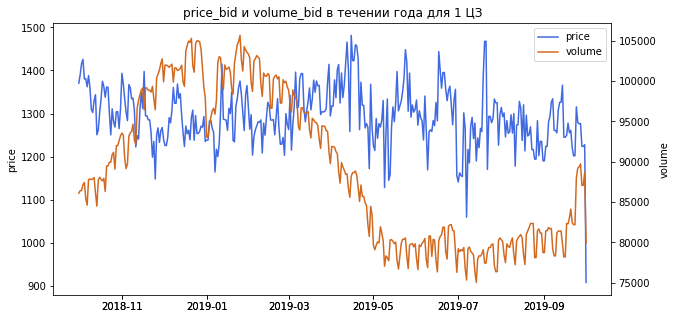

In [128]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111, label=1)
ax2 = fig.add_subplot(111, label=2, frame_on=False)

line1 = ax1.plot(df_indices['date'], df_indices['price_bid'], label='price', c='royalblue')

line2 = ax2.plot(df_indices['date'], df_indices['volume_bid'], label='volume',  c='chocolate')
ax2.yaxis.tick_right()

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_ylabel('price')
ax2.yaxis.set_label_position('right') 
ax2.set_ylabel('volume')

plt.title('price_bid и volume_bid в течении года для 1 ЦЗ')
plt.show()

### Поиск структуры в данных

Для кластеризации генерирующих единиц определим признаки, их характирезующие:
* Среднее значение pdg - mean_pdg.
* Среднее значение верхнего лимита производства - mean_limit.
* Разница между средним значением верхнего лимита и средним значением pdg - mean_diff_lim_act (должно характерезовать то, насколько эффективно генерирующая единица работает).
* Количество дней когда pdg == 0, т.е. генерирующая единица не работала - broke_days.
* Средняя цена для данной генерирубщей единицы - mean_price.
* Разница между средним значением равновесной цены для 1 ЦЗ и средним значением цены для генерирующей единицы - diff_mean_price (должно зарактеризовать насколько дешевле/дороже стоит продукция ген. единицы по сравнению с ценами в 1 ЦЗ).
* Средняя цена за продукцию в соответствующем регионе - mean_region_price.
* Разница между средней ценой в регионе и средней ценой у данной ген. единицы - mean_diff_region_price.

Рассмотрим в начале структуру без учета изменения во времени, а за весь промежуток целиком.

In [22]:
df_units['diff_limit_actual'] = df_units['upper_limit'] - df_units['pdg']
df_units['broke_day'] = df_units['pdg'].apply(lambda x: int(x == 0.0))

df_nodes_info = pd.DataFrame(df_units.groupby('node_id')['pdg'].mean().sort_index()).reset_index()
df_nodes_info.columns = ['node_id', 'mean_pdg']

df_nodes_info['mean_limit'] = df_units.groupby('node_id')['upper_limit'].mean().sort_index().values
df_nodes_info['mean_diff_lim_act'] = df_units.groupby('node_id')['diff_limit_actual'].mean().sort_index().values
df_nodes_info['broke_days'] = df_units.groupby('node_id')['broke_day'].sum().sort_index().values

df_mean_prices = pd.DataFrame(df_prices.groupby('node_id')['price'].mean()).reset_index()
df_mean_prices.columns = ['node_id', 'mean_price']
df_nodes_info = pd.merge(df_nodes_info, df_mean_prices, on='node_id', how='left')

df_nodes_info['diff_mean_price'] = df_prices['price'].mean() - df_nodes_info['mean_price']

df_nodes_info = pd.merge(df_nodes_info, df_nodes, on='node_id', how='left')
df_regions_prices = pd.DataFrame(pd.merge(df_prices, df_nodes, on='node_id', how='left'
                                         ).groupby('region')['price'].mean()).reset_index()
df_regions_prices.columns = ['region', 'mean_region_price']
df_nodes_info = pd.merge(df_nodes_info, df_regions_prices, on='region', how='left')
df_nodes_info['mean_diff_region_price'] = df_nodes_info['mean_region_price'] - df_nodes_info['mean_price']

In [23]:
features_names = ['mean_pdg', 'mean_limit', 'mean_diff_lim_act', 'broke_days',
                  'mean_price', 'diff_mean_price', 'mean_region_price',
                  'mean_diff_region_price']

In [24]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [25]:
tsne = TSNE(n_components=2)
# Y = tsne.fit_transform(df_nodes_info[['mean_pdg', 'mean_limit', 'mean_diff_lim_act', 'broke_days']])
Y = tsne.fit_transform(df_nodes_info[features_names])

In [35]:
kmeans = KMeans(n_clusters=10)
# clusters = kmeans.fit_predict(df_nodes_info[['mean_pdg', 'mean_limit', 'mean_diff_lim_act', 'broke_days']])
clusters = kmeans.fit_predict(df_nodes_info[features_names])

In [53]:
import pickle

with open('model_kmeans_v0', 'wb') as file:
    pickle.dump(kmeans, file)

Сделаем класетиразию методом KMeans на созданных признаках, и также создадим с помощью t-SNE проекцию исходного признакового пространства на двумерную плоскость для возможности отрисовать полученные кластера.

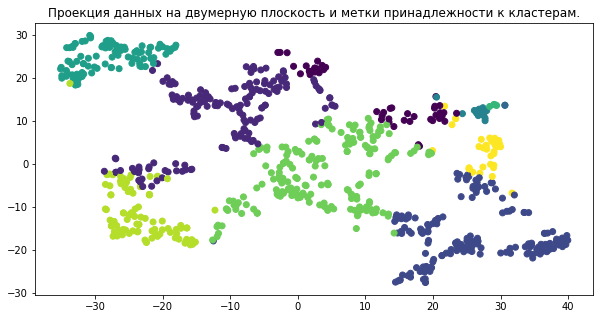

In [36]:
plt.figure(figsize=(10, 5))
plt.scatter(Y[:, 0], Y[:, 1], c=clusters)
plt.title('Проекция данных на двумерную плоскость и метки принадлежности к кластерам.')
plt.show()

Заметно выделяются 5 естевственных, хорошо разделимых, кластеров, так же есть пара совсем маленьких класеторв, которые скорее всего отвечают явным выбросам.

Рассмотрим кластера в разрезе исходных признаков.

In [41]:
df_nodes_info.to_csv('df_nodes_info_clust_v0.csv', index=False)

In [20]:
df_nodes_info = pd.read_csv('df_nodes_info_clust_v0.csv')
# df_nodes_info.head()

In [21]:
df_nodes_info['clusters'] = clusters.astype(float)
df_nodes_info['clusters'].value_counts()

7.0    194
2.0    161
1.0    158
8.0     95
5.0     93
0.0     47
9.0     35
4.0     14
6.0      4
3.0      2
Name: clusters, dtype: int64

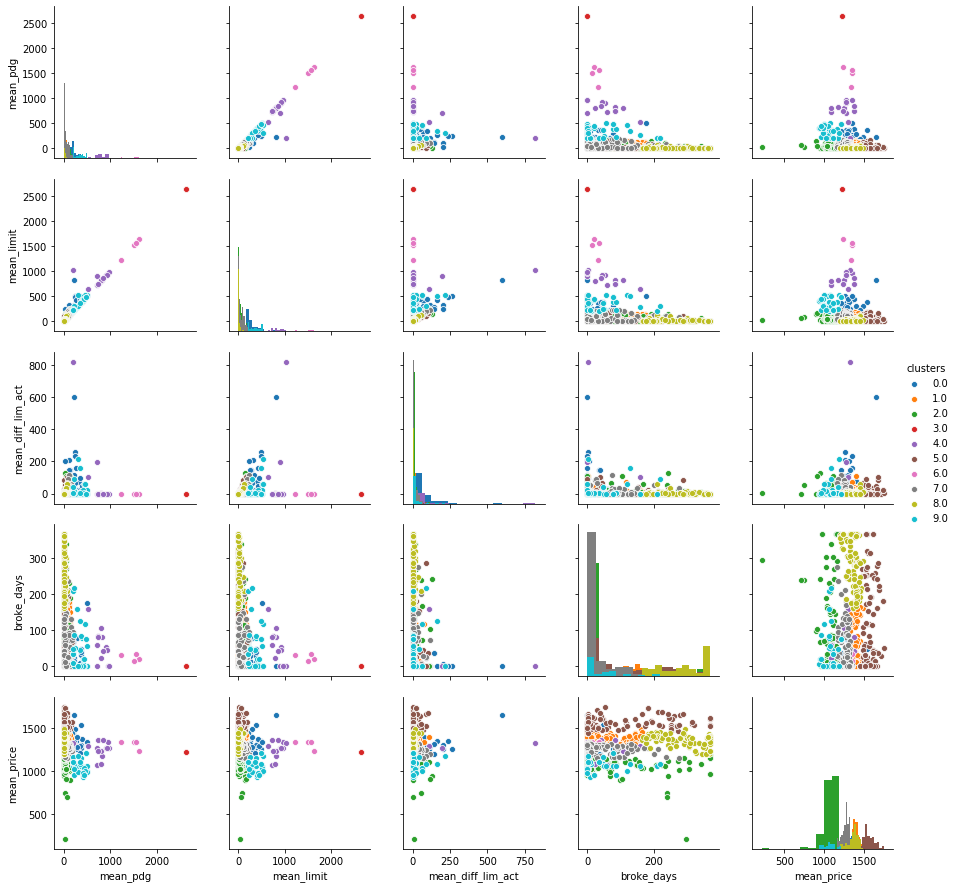

In [38]:
sns.pairplot(data=df_nodes_info, hue='clusters', diag_kind='hist',
             vars=features_names[:5])
plt.show()

Из данных графиков видны следующие идеи:
* Серому кластеру (номер 8) соответсвтвуют единицы, с очень большим числом нерабочих дней (broke_days) и малым объемом выработки (pdg) - что видно из графика на пресечении. Так же цена на продукцию в этом кластере около средней ~ 1300-1400.
* Тёмно-зелёному кластеру (номер 2) и светло-зелёному (номер 9) - соответсвуют объекты у которых очень низкая цена (mean_price) (около 1000), но темно-зеленый кластер также определяет маленький уровень производительности (mean_pdg).
* Тёмно-фиолетовому кластеру (номер 5) соответствует большая цена на продукцию (около 1500).
* Тёмно-оранжевый (номер 6) определяется очень большим уровнем производительности (в среднем 1500 для кластера) при средней цене.

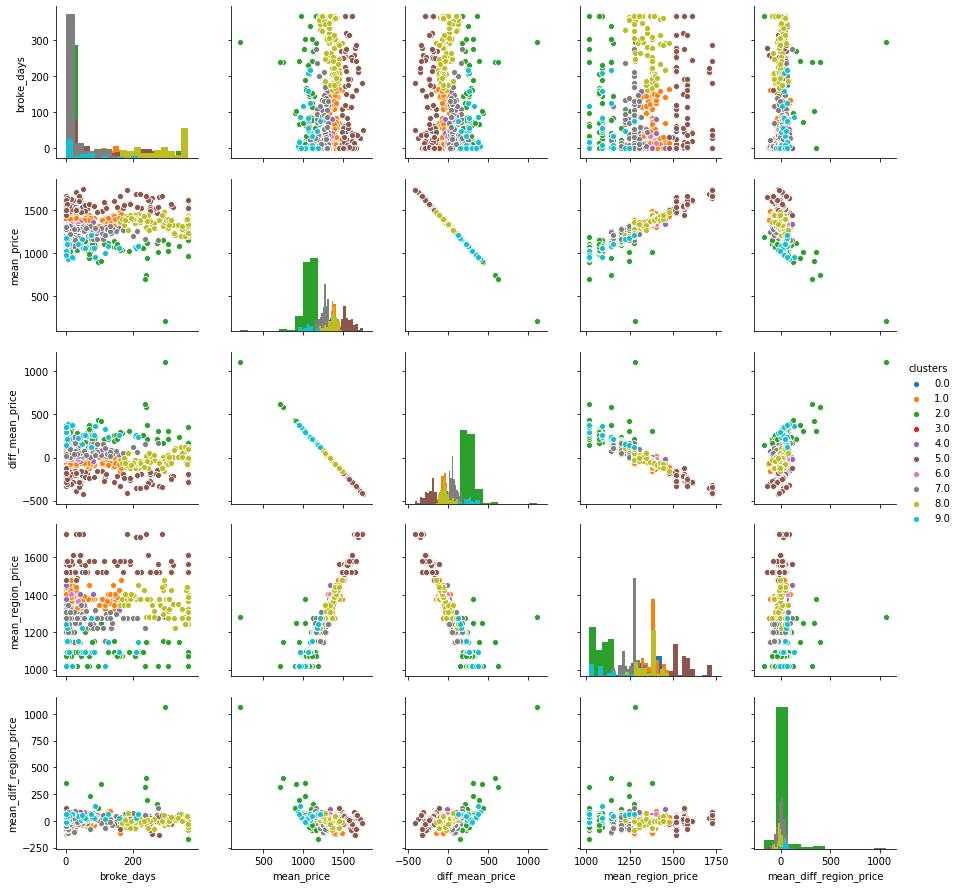

In [43]:
sns.pairplot(data=df_nodes_info, hue='clusters', diag_kind='hist',
             vars=features_names[3:])
plt.show()

Из графика выше также видно, что средняя цена по региону (график mean_region_price) хорошо разделяет кластера, что говорит о том, что возможно элементы кластера принаддлежат к одному (или к похожим между собой) региону/регионам. Т.е. класетра разделимы в понятиях ценовых категорий.

#### Вывод:
     
     главным образом класетра хорошо разделимы в понятиях цены их продукции, принадлежности к регионам с примерно одинаковой средней ценой, исходя из производительности ген. единицы и исходя из числа нерабочих дней.

Рассмотрим как показатели менялись во времени внутри данных кластеров. Возьмем два промежутка: декабрь 2018 и сентябрь 2019.

In [21]:
df_nodes_info_2018 = df_nodes_info[['node_id', 'clusters']]
df_nodes_info_2019 = df_nodes_info[['node_id', 'clusters']]

# PDG
df_units['month'] = df_units['date'].apply(lambda x: x.month)
df_nodes_info_2018 = pd.merge(df_nodes_info_2018, df_units[df_units['month'] == 12
                                                          ].groupby('node_id')['pdg'].mean(),
                              on='node_id', how='left')
df_nodes_info_2019 = pd.merge(df_nodes_info_2019, df_units[df_units['month'] == 9
                                                          ].groupby('node_id')['pdg'].mean(),
                              on='node_id', how='left')

# Количество дней простойки
df_units['broke_day'] = df_units['pdg'].apply(lambda x: int(x == 0.0))
df_nodes_info_2018 = pd.merge(df_nodes_info_2018, df_units[df_units['month'] == 12
                                                          ].groupby('node_id')['broke_day'].sum(),
                              on='node_id', how='left')
df_nodes_info_2019 = pd.merge(df_nodes_info_2019, df_units[df_units['month'] == 9
                                                          ].groupby('node_id')['broke_day'].sum(),
                              on='node_id', how='left')

# Средняя цена на продукцию
df_prices['date'] = pd.to_datetime(df_prices['date'])
df_prices['month'] = df_prices['date'].apply(lambda x: x.month)
df_nodes_info_2018 = pd.merge(df_nodes_info_2018, df_prices[df_prices['month'] == 12
                                                           ].groupby('node_id')['price'].mean(), on='node_id', how='left')
df_nodes_info_2019 = pd.merge(df_nodes_info_2019, df_prices[df_prices['month'] == 9
                                                           ].groupby('node_id')['price'].mean(), on='node_id', how='left')

# Средняя цена в регионе
df_nodes_info_2018 = pd.merge(df_nodes_info_2018, df_nodes, on='node_id', how='left')
df_nodes_info_2019 = pd.merge(df_nodes_info_2019, df_nodes, on='node_id', how='left')

df_region_prices_2018 = pd.DataFrame(pd.merge(df_prices[df_prices['month'] == 12], df_nodes, on='node_id', how='left'
                                             ).groupby('region')['price'].mean()).reset_index()
df_region_prices_2019 = pd.DataFrame(pd.merge(df_prices[df_prices['month'] == 9], df_nodes, on='node_id', how='left'
                                             ).groupby('region')['price'].mean()).reset_index()
df_region_prices_2018.columns = ['region', 'mean_region_price']
df_region_prices_2019.columns = ['region', 'mean_region_price']

df_nodes_info_2018 = pd.merge(df_nodes_info_2018, df_region_prices_2018, on='region', how='left')
df_nodes_info_2019 = pd.merge(df_nodes_info_2019, df_region_prices_2019, on='region', how='left')

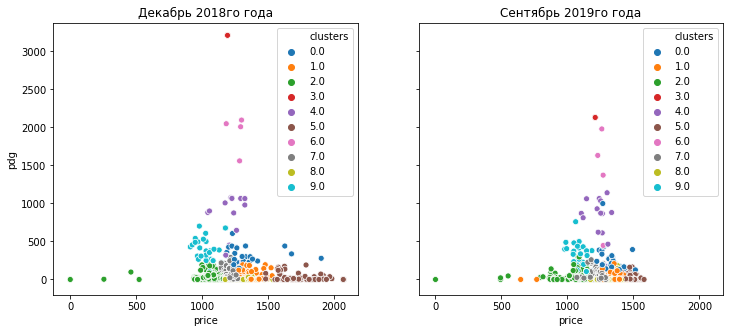

In [48]:
fig = plt.figure(figsize=(12, 5))
current_palette = sns.color_palette()
axs = fig.subplots(ncols=2, sharey=True, sharex=True)

sns.scatterplot(x=df_nodes_info_2018['price'], y=df_nodes_info_2018['pdg'],
                hue=df_nodes_info_2018['clusters'], ax=axs[0], palette=current_palette)
sns.scatterplot(x=df_nodes_info_2019['price'], y=df_nodes_info_2019['pdg'],
                hue=df_nodes_info_2019['clusters'], ax=axs[1], palette=current_palette)

axs[0].title.set_text('Декабрь 2018го года')
axs[1].title.set_text('Сентябрь 2019го года')

Видим, что во-первых цена в кластере номер 5 (темно-фиолетовый/коричневый) в среднем заметно снизилась, если раньше внутри кластера она была ~ 1500-2000, то на втором графике она уже ~ 1500. Так же велична производства в темно-оранжевом кластере (номер 6) в среднем упала. Остальные кластера изменились похожим образом, но не так явно.

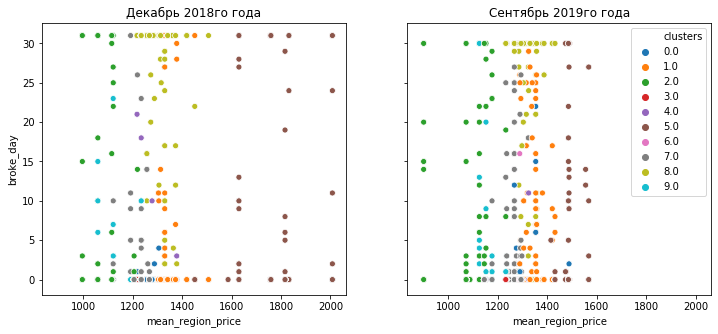

In [52]:
fig = plt.figure(figsize=(12, 5))
current_palette = sns.color_palette()
axs = fig.subplots(ncols=2, sharey=True, sharex=True)

sns.scatterplot(x=df_nodes_info_2018['mean_region_price'], y=df_nodes_info_2018['broke_day'],
                hue=df_nodes_info_2018['clusters'], ax=axs[0], palette=current_palette, legend=None)
sns.scatterplot(x=df_nodes_info_2019['mean_region_price'], y=df_nodes_info_2019['broke_day'],
                hue=df_nodes_info_2019['clusters'], ax=axs[1], palette=current_palette)

axs[0].title.set_text('Декабрь 2018го года')
axs[1].title.set_text('Сентябрь 2019го года')

Аналогично, средняя цена на продукцию по регионам соответсвующим 5ому кластеру сильно упала. И так же для большинаства кластеров увеличилось число нерабочих дней, т.к. в декабре вся масса была сконцетрирована в нижей части графика, в сентябре - увеличилась плотность точек в центре графика.